# Proyek Klasifikasi Gambar: animals10
- **Nama:** Reynaldy Siamnungkalit
- **Email:** mc172d5y1311@student.devacademy.id
- **ID Dicoding:** MC172D5Y1311

## Import Semua Packages/Library yang Digunakan

In [1]:
from google.colab import files
files.upload()  # upload kaggle.json dari komputermu


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aldy776","key":"c1071d6743b29ea1bffae7d6afaacd5d"}'}

In [2]:
!pip install -q kaggle


In [3]:
!pip install --upgrade numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 34.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.


In [4]:
!pip install tensorflow                  # Pasang ulang TensorFlow
!pip install tensorflow-model-optimization  # Tambahkan optimisasi model
!pip install --upgrade keras             # Perbarui Keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 29.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 39.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!pip install split-folders

In [1]:
# Import Semua Packages/Library yang Digunakan
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
from PIL import Image
import shutil
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_model_optimization as tfmot
import time
import json

In [2]:
import tensorflow as tf

# Mengecek ketersediaan GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  1
TensorFlow version: 2.18.0


## Data Preparation

### Data Loading

In [3]:
!KAGGLE_USERNAME="aldy776" KAGGLE_KEY="c1071d6743b29ea1bffae7d6afaacd5d" kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0


In [ ]:

extract_path = '/content/data'
os.makedirs(extract_path, exist_ok=True)

# Unzip dataset
import zipfile
zip_file = 'animals10.zip'  # nama file hasil download dari Kaggle

try:
    print("Ekstraksi dimulai...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset berhasil diekstrak ke: {extract_path}")
except zipfile.BadZipFile:
    print("Gagal mengekstrak: file zip rusak atau tidak valid")
except Exception as e:
    print(f"Terjadi kesalahan: {str(e)}")

Ekstraksi dimulai...
Dataset berhasil diekstrak ke: /content/data


In [ ]:
import os

dataset_dir = '/content/data/raw-img'

if not os.path.exists(dataset_dir):

    extracted_folders = os.listdir('/content/data')
    for folder in extracted_folders:
        folder_path = os.path.join('/content/data', folder)
        if os.path.isdir(folder_path):  
            dataset_dir = folder_path
            break

# Inisialisasi counter
total_images = 0
valid_extensions = ('.jpeg', '.jpg', '.png', '.JPG', '.JPEG', '.PNG')

# Cek apakah dataset_dir valid
if not os.path.exists(dataset_dir):
    print("Dataset tidak ditemukan di path yang diharapkan.")
    exit()

# Hitung total gambar
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(valid_extensions)]
        total_images += len(images)

# Tampilkan hasil total saja
print(f"TOTAL GAMBAR: {total_images} gambar")


TOTAL GAMBAR: 26179 gambar


### Data Preprocessing

In [6]:
# === DATA PREPROCESSING ===
print("\n=== DATA PREPROCESSING ===")

# Path ke dataset yang diekstrak
dataset_dir = '/content/data/raw-img'

# Impor dictionary translate dari file translate.py
import sys
sys.path.append('/content/data')  # atau path lain yang sesuai
from translate import translate


# Periksa dan tampilkan semua kategori (folder) dalam dataset
classes = os.listdir(dataset_dir)
translated_classes = [translate.get(cls, cls) for cls in classes]
print(f"Kategori hewan dalam dataset (original): {classes}")
print(f"Kategori hewan dalam dataset (translated): {translated_classes}")

# Function untuk menampilkan jumlah gambar dan resolusi
def print_images_info(directory):
    unique_sizes = set()
    class_counts = {}
    total_images = 0

    print("\nInformasi Dataset:")
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            num_images = len(image_files)
            class_counts[class_name] = num_images
            total_images += num_images

            # Catat resolusi untuk statistik
            for img_file in image_files[:1]:  # Cek hanya 1 gambar per kelas untuk resolusi
                img_path = os.path.join(class_path, img_file)
                with Image.open(img_path) as img:
                    unique_sizes.add(img.size)
                break

    print("\nTotal ukuran resolusi unik:", len(unique_sizes))
    print("Total gambar:", total_images)

    # Tampilkan distribusi kelas (dengan terjemahan)
    print("\nDistribusi jumlah gambar per kelas:")
    for class_name, count in class_counts.items():
        translated_name = translate.get(class_name, class_name)
        print(f"{class_name} ({translated_name}): {count} gambar")

# Panggil fungsi untuk mendapatkan informasi dataset
print_images_info(dataset_dir)


=== DATA PREPROCESSING ===
Kategori hewan dalam dataset (original): ['scoiattolo', 'mucca', 'ragno', 'pecora', 'gallina', 'farfalla', 'cane', 'gatto', 'cavallo', 'elefante']
Kategori hewan dalam dataset (translated): ['squirrel', 'cow', 'ragno', 'sheep', 'chicken', 'butterfly', 'dog', 'cat', 'horse', 'elephant']

Informasi Dataset:

Total ukuran resolusi unik: 9
Total gambar: 26179

Distribusi jumlah gambar per kelas:
scoiattolo (squirrel): 1862 gambar
mucca (cow): 1866 gambar
ragno (ragno): 4821 gambar
pecora (sheep): 1820 gambar
gallina (chicken): 3098 gambar
farfalla (butterfly): 2112 gambar
cane (dog): 4863 gambar
gatto (cat): 1668 gambar
cavallo (horse): 2623 gambar
elefante (elephant): 1446 gambar


#### Split Dataset

In [ ]:
# ========================
# 2. DATA SPLITTING (SIMPLE VERSION)
# ========================
import splitfolders
import os


raw_data_dir = "/content/data/raw-img"


output_dir = "/content/processed_dataset"

# Split dataset dengan 1 baris kode
splitfolders.ratio(
    raw_data_dir,           
    output=output_dir,      
    seed=42,                 
    ratio=(0.8, 0.1, 0.1),   
    group_prefix=None,       
    move=False               
)


# 3. MENAMPILKAN JUMLAH GAMBAR DI MASING-MASING DataSET

def count_images_per_set(base_dir):
    for subset in ["train", "val", "test"]:
        subset_dir = os.path.join(base_dir, subset)
        print(f"\nJumlah gambar pada '{subset}' set:")
        for class_name in os.listdir(subset_dir):
            class_dir = os.path.join(subset_dir, class_name)
            if os.path.isdir(class_dir):
                num_images = len(os.listdir(class_dir))
                print(f"  {class_name}: {num_images} gambar")

count_images_per_set(output_dir)


Copying files: 26179 files [00:03, 6721.84 files/s]


Jumlah gambar pada 'train' set:
  scoiattolo: 1489 gambar
  mucca: 1492 gambar
  ragno: 3856 gambar
  pecora: 1456 gambar
  gallina: 2478 gambar
  farfalla: 1689 gambar
  cane: 3890 gambar
  gatto: 1334 gambar
  cavallo: 2098 gambar
  elefante: 1156 gambar

Jumlah gambar pada 'val' set:
  scoiattolo: 186 gambar
  mucca: 186 gambar
  ragno: 482 gambar
  pecora: 182 gambar
  gallina: 309 gambar
  farfalla: 211 gambar
  cane: 486 gambar
  gatto: 166 gambar
  cavallo: 262 gambar
  elefante: 144 gambar

Jumlah gambar pada 'test' set:
  scoiattolo: 187 gambar
  mucca: 188 gambar
  ragno: 483 gambar
  pecora: 182 gambar
  gallina: 311 gambar
  farfalla: 212 gambar
  cane: 487 gambar
  gatto: 168 gambar
  cavallo: 263 gambar
  elefante: 146 gambar


## Modelling

In [ ]:
# ================== Import Library ==================
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import os


IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

# Persiapan Data 
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/processed_dataset/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/processed_dataset/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_directory(
    '/content/processed_dataset/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Bangun Model
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax')  # dinamis sesuai jumlah kelas
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks 
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-5),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

#Training 
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)


Found 20938 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.
Found 2627 images belonging to 10 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7193 - loss: 0.9235

655/655 ━━━━━━━━━━━━━━━━━━━━ 282s 412ms/step - accuracy: 0.7195 - loss: 0.9231 - val_accuracy: 0.9269 - val_loss: 0.2722 - learning_rate: 0.0010
Epoch 2/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 238s 363ms/step - accuracy: 0.8752 - loss: 0.4330 - val_accuracy: 0.9227 - val_loss: 0.2998 - learning_rate: 0.0010
Epoch 3/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8834 - loss: 0.4153

655/655 ━━━━━━━━━━━━━━━━━━━━ 237s 362ms/step - accuracy: 0.8834 - loss: 0.4153 - val_accuracy: 0.9323 - val_loss: 0.2432 - learning_rate: 0.0010
Epoch 4/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 242s 369ms/step - accuracy: 0.9005 - loss: 0.3399 - val_accuracy: 0.9265 - val_loss: 0.2597 - learning_rate: 0.0010
Epoch 5/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 235s 359ms/step - accuracy: 0.9085 - loss: 0.3206 - val_accuracy: 0.9285 - val_loss: 0.2883 - learning_rate: 0.0010
Epoch 6/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 241s 367ms/step - accuracy: 0.9112 - loss: 0.3103 - val_accuracy: 0.9323 - val_loss: 0.2475 - learning_rate: 0.0010
Epoch 7/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9276 - loss: 0.2371

655/655 ━━━━━━━━━━━━━━━━━━━━ 237s 362ms/step - accuracy: 0.9276 - loss: 0.2371 - val_accuracy: 0.9461 - val_loss: 0.2115 - learning_rate: 5.0000e-04
Epoch 8/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 237s 362ms/step - accuracy: 0.9363 - loss: 0.2147 - val_accuracy: 0.9449 - val_loss: 0.2116 - learning_rate: 5.0000e-04
Epoch 9/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9370 - loss: 0.2025

655/655 ━━━━━━━━━━━━━━━━━━━━ 240s 367ms/step - accuracy: 0.9370 - loss: 0.2025 - val_accuracy: 0.9472 - val_loss: 0.2085 - learning_rate: 5.0000e-04
Epoch 10/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 238s 363ms/step - accuracy: 0.9412 - loss: 0.1934 - val_accuracy: 0.9453 - val_loss: 0.2089 - learning_rate: 5.0000e-04
Epoch 11/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 242s 369ms/step - accuracy: 0.9399 - loss: 0.1930 - val_accuracy: 0.9415 - val_loss: 0.2181 - learning_rate: 5.0000e-04
Epoch 12/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 238s 364ms/step - accuracy: 0.9462 - loss: 0.1774 - val_accuracy: 0.9403 - val_loss: 0.2095 - learning_rate: 5.0000e-04
Epoch 13/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9470 - loss: 0.1696

655/655 ━━━━━━━━━━━━━━━━━━━━ 265s 369ms/step - accuracy: 0.9470 - loss: 0.1696 - val_accuracy: 0.9480 - val_loss: 0.2030 - learning_rate: 2.5000e-04
Epoch 14/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9494 - loss: 0.1569

655/655 ━━━━━━━━━━━━━━━━━━━━ 241s 368ms/step - accuracy: 0.9494 - loss: 0.1569 - val_accuracy: 0.9461 - val_loss: 0.1975 - learning_rate: 2.5000e-04
Epoch 15/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9508 - loss: 0.1615

655/655 ━━━━━━━━━━━━━━━━━━━━ 238s 364ms/step - accuracy: 0.9508 - loss: 0.1615 - val_accuracy: 0.9449 - val_loss: 0.1958 - learning_rate: 2.5000e-04
Epoch 16/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 244s 372ms/step - accuracy: 0.9511 - loss: 0.1521 - val_accuracy: 0.9476 - val_loss: 0.1986 - learning_rate: 2.5000e-04
Epoch 17/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 237s 362ms/step - accuracy: 0.9537 - loss: 0.1471 - val_accuracy: 0.9430 - val_loss: 0.2002 - learning_rate: 2.5000e-04
Epoch 18/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9558 - loss: 0.1413

655/655 ━━━━━━━━━━━━━━━━━━━━ 240s 366ms/step - accuracy: 0.9558 - loss: 0.1413 - val_accuracy: 0.9484 - val_loss: 0.1940 - learning_rate: 2.5000e-04
Epoch 19/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9530 - loss: 0.1503

655/655 ━━━━━━━━━━━━━━━━━━━━ 238s 363ms/step - accuracy: 0.9530 - loss: 0.1503 - val_accuracy: 0.9480 - val_loss: 0.1888 - learning_rate: 2.5000e-04
Epoch 20/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 238s 363ms/step - accuracy: 0.9581 - loss: 0.1300 - val_accuracy: 0.9526 - val_loss: 0.1959 - learning_rate: 2.5000e-04
Epoch 21/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 266s 369ms/step - accuracy: 0.9556 - loss: 0.1352 - val_accuracy: 0.9453 - val_loss: 0.2030 - learning_rate: 2.5000e-04
Epoch 22/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 240s 366ms/step - accuracy: 0.9575 - loss: 0.1260 - val_accuracy: 0.9445 - val_loss: 0.1947 - learning_rate: 2.5000e-04
Epoch 23/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9565 - loss: 0.1258

655/655 ━━━━━━━━━━━━━━━━━━━━ 239s 365ms/step - accuracy: 0.9565 - loss: 0.1258 - val_accuracy: 0.9495 - val_loss: 0.1812 - learning_rate: 1.2500e-04
Epoch 24/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 237s 362ms/step - accuracy: 0.9552 - loss: 0.1350 - val_accuracy: 0.9487 - val_loss: 0.1813 - learning_rate: 1.2500e-04
Epoch 25/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 243s 371ms/step - accuracy: 0.9602 - loss: 0.1206 - val_accuracy: 0.9503 - val_loss: 0.1869 - learning_rate: 1.2500e-04
Epoch 26/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 260s 369ms/step - accuracy: 0.9611 - loss: 0.1234 - val_accuracy: 0.9499 - val_loss: 0.1861 - learning_rate: 1.2500e-04
Epoch 27/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 260s 366ms/step - accuracy: 0.9639 - loss: 0.1112 - val_accuracy: 0.9487 - val_loss: 0.1854 - learning_rate: 6.2500e-05
Epoch 28/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 240s 366ms/step - accuracy: 0.9631 - loss: 0.1116 - val_accuracy: 0.9518 - val_loss: 0.1824 - learning_rate: 6.2500e-05


## Evaluasi dan Visualisasi

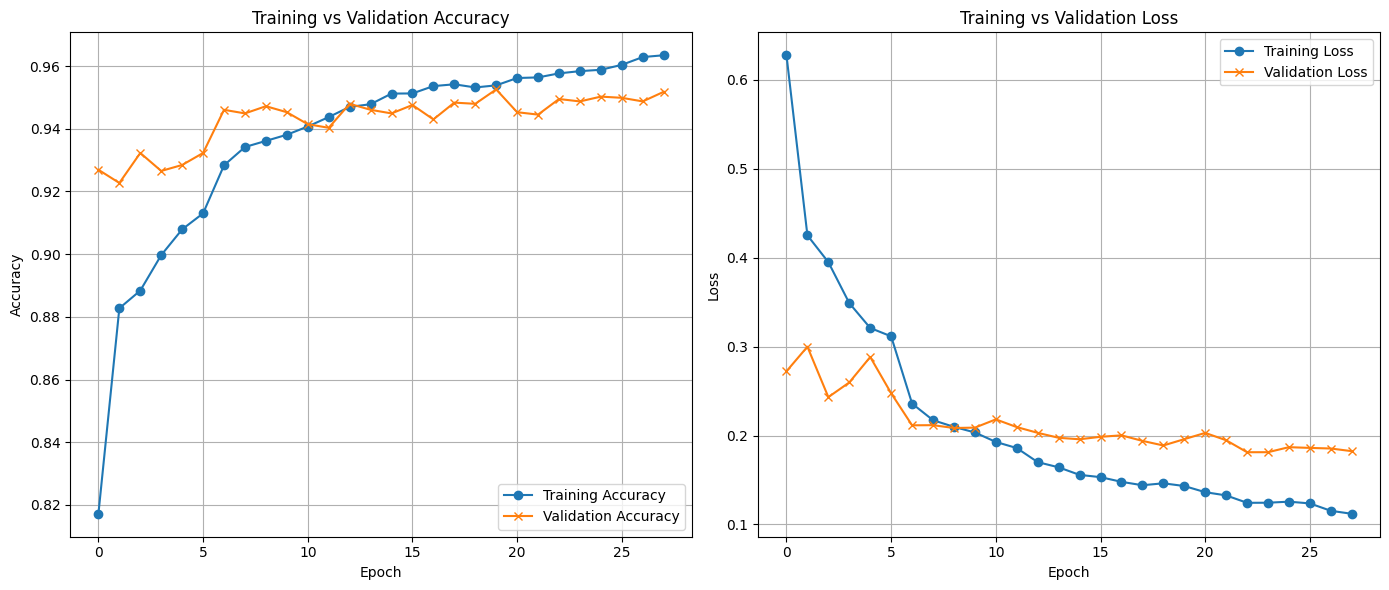

In [ ]:
import matplotlib.pyplot as plt
import os

# Gunakan direktori 'saved_model' sesuai struktur yang diinginkan
plot_dir = 'saved_model'
os.makedirs(plot_dir, exist_ok=True)

# Plot Accuracy dan Loss Selama Training
plt.figure(figsize=(14, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Simpan dan tampilkan
plt.tight_layout()
plt.show()

In [11]:
# Ambil nilai terakhir dari history training
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Evaluasi model pada test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

# Cetak hasil akhir
print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.9451 - loss: 0.2125

Final Training Accuracy: 0.9635
Final Validation Accuracy: 0.9518
Final Training Loss: 0.1120
Final Validation Loss: 0.1824
Final Test Accuracy: 0.9467
Final Test Loss: 0.2078


## Konversi Model

In [ ]:
import os
import shutil
import tensorflow as tf
import json
import sys

# Tambahkan path untuk modul translate
sys.path.append('/content/data')
from translate import translate

print("\n=== PROSES KONVERSI MODEL ===")

def persiapkan_direktori(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

# 1. Simpan model dalam format SavedModel
persiapkan_direktori('saved_model')
tf.saved_model.save(model, 'saved_model')
print("Berhasil menyimpan model format SavedModel di:")
print("saved_model/saved_model.pb")
print("saved_model/variables/...")

# 2. Konversi ke TensorFlow Lite
persiapkan_direktori('tflite')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)
print("\nBerhasil menyimpan model TFLite di: tflite/model.tflite")

# 3. Buat label.txt
try:
    class_mapping = {v: k for k, v in train_generator.class_indices.items()}
    terjemahan = [translate.get(cls, cls) for cls in class_mapping.values()]

    with open('tflite/label.txt', 'w') as f:
        for nama in terjemahan:
            f.write(f"{nama}\n")

    print("Berhasil menyimpan label di: tflite/label.txt")

except Exception as e:
    print(f"Gagal membuat label: {str(e)}")

# 4. Konversi ke TensorFlow.js
persiapkan_direktori('tfjs_model')

try:
    import tensorflowjs as tfjs
except ImportError:
    !pip install tensorflowjs
    import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'tfjs_model')
print("\nBerhasil menyimpan model TFJS di:")
print("tfjs_model/model.json")
print("tfjs_model/group1-shard*")



=== PROSES KONVERSI MODEL ===
Berhasil menyimpan model format SavedModel di:
saved_model/saved_model.pb
saved_model/variables/...
Saved artifact at '/tmp/tmpl5yiaigf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133003460024976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133001621671568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133001621670032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133001621672912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133001621673296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133003460024592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133001621672720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133001621671376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133001621673680: T


Berhasil menyimpan model TFLite di: tflite/model.tflite
Berhasil menyimpan label di: tflite/label.txt
failed to lookup keras version from the file,
    this is likely a weight only file

Berhasil menyimpan model TFJS di:
tfjs_model/model.json
tfjs_model/group1-shard*


## Inference (Optional)

INFERENSI MODEL


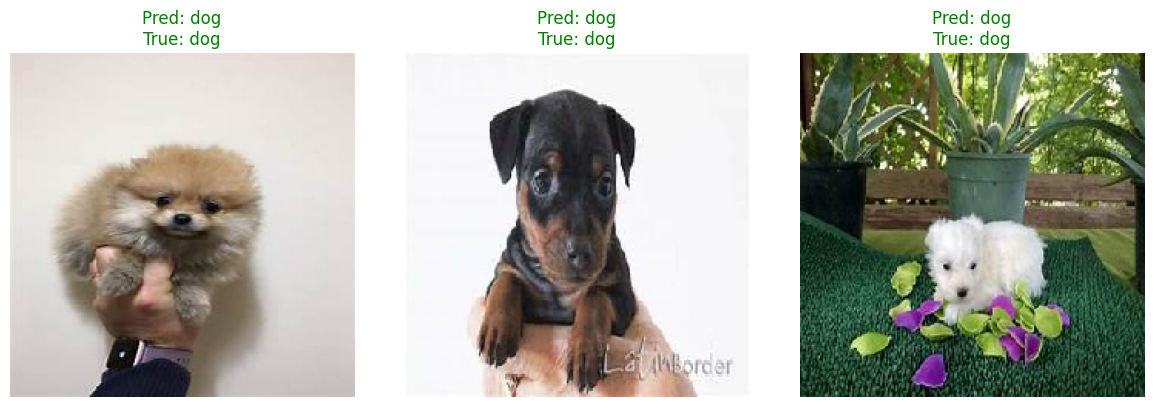

In [ ]:
# ================== INFERENSI MODEL ==================
print("INFERENSI MODEL")

from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np
import tensorflow as tf
import sys

sys.path.append('/content/data')
try:
    from translate import translate
except ImportError:
    raise ImportError("File translate.py tidak ditemukan di /content/data")

# Muat model terbaik dengan penanganan error
try:
    model_terbaik = load_model('best_model.h5', compile=False)
    model_terbaik.compile()
except Exception as e:
    raise RuntimeError(f"Gagal memuat model: {str(e)}")

def prediksi_dan_visualisasi():
    try:
        # Ambil 3 sampel test
        test_images, test_labels = next(test_generator)
        predictions = model_terbaik.predict(test_images[:3], verbose=0)

        # Proses hasil
        pred_kelas = np.argmax(predictions, axis=1)
        true_kelas = np.argmax(test_labels[:3], axis=1)

        # Dapatkan nama kelas
        class_names = list(test_generator.class_indices.keys())

        # Visualisasi
        plt.figure(figsize=(12, 4))
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.imshow(test_images[i])

            # Gunakan kamus translate
            pred_label = translate.get(class_names[pred_kelas[i]], class_names[pred_kelas[i]])
            true_label = translate.get(class_names[true_kelas[i]], class_names[true_kelas[i]])

            warna = 'green' if pred_kelas[i] == true_kelas[i] else 'red'
            plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=warna)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error visualisasi: {str(e)}")

prediksi_dan_visualisasi()




=== PREDIKSI GAMBAR KUSTOM ===
Upload gambar hewan (format JPG/PNG)


Saving ss12.jpg to ss12 (1).jpg


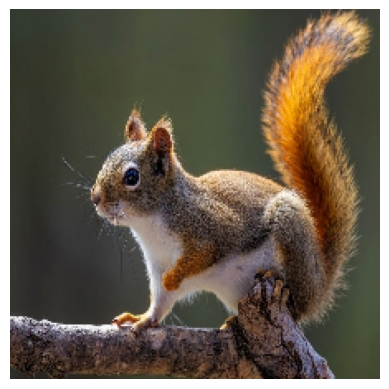


HASIL PREDIKSI: squirrel
Tingkat Kepercayaan: 23.20%


In [ ]:
def prediksi_gambar_kustom():
    print("\n=== PREDIKSI GAMBAR KUSTOM ===")
    print("Upload gambar hewan (format JPG/PNG)")

    uploaded = files.upload()

    for nama_file in uploaded.keys():
        try:
            # Preprocess gambar
            img = tf.keras.utils.load_img(
                '/content/' + nama_file,
                target_size=IMG_SIZE,
                color_mode='rgb'
            )
            img_array = tf.keras.utils.img_to_array(img)/255.0
            img_array = tf.expand_dims(img_array, 0)

            # Prediksi
            prediksi = model_terbaik.predict(img_array, verbose=0)
            skor = tf.nn.softmax(prediksi[0])

            # mengambil prediksi teratas
            kelas_teratas = np.argmax(skor)
            nama_kelas = list(test_generator.class_indices.keys())[kelas_teratas]
            nama_indonesia = translate.get(nama_kelas, nama_kelas)
            persentase = 100 * np.max(skor)

            plt.imshow(img)
            plt.axis('off')
            plt.show()

            print(f"\nHASIL PREDIKSI: {nama_indonesia}")
            print(f"Tingkat Kepercayaan: {persentase:.2f}%")

        except Exception as e:
            print(f"\nError: {str(e)}")

prediksi_gambar_kustom()